In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
import skimage
import random
from skimage import data
from skimage import io
from skimage import feature
from skimage.color import rgb2gray
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py
from PIL import Image
import os
from random import shuffle


# fixed-sizes for image
fixed_size = tuple((300, 300))

# path to training data
file_path = '/Users/arlomalmberg/Documents/GSPP/Semester 2/DS100/final_project/20_categories_training/20_categories_training'

# no.of.trees for Random Forests
num_trees = 100

# bins for histogram
bins = 8

# train_test_split size
test_size = 0.10

# seed for reproducing same results
seed = 9

In [2]:
# Recode dictionary for use in the final function

recode_dict = {0:'airplanes',
1:'bear',
2:'blimp',
3:'comet',
4:'crab',
5:'dog',
6:'dolphin',
7:'giraffe',
8:'goat',
9:'gorilla',
10:'kangaroo',
11:'killer-whale',
12:'leopards',
13:'llama',
14:'penguin',
15:'porcupine',
16:'teddy-bear',
17:'triceratops',
18:'unicorn',
19:'zebra'}

# Flips keys and values for use in final function

recode = {y:x for x,y in recode_dict.items()}

In [3]:
def ft0(image):
    return image.size
# Returns the pixel size of the image

def ft1(image):
    reds = []
    for i in range(len(image)):
        reds.append(image[i][0][0])
    return np.mean(reds)
# Returns the average of the red-channel pictures for the images

def ft2(image):
    greens = []
    for i in range(len(image)):
        greens.append(image[i][0][1])
    return np.mean(greens)
# Returns the average of the green-channel pictures for the images

def ft3(image):
    blues = []
    for i in range(len(image)):
        blues.append(image[i][0][2])
    return np.mean(blues)
# Returns the average of the blue-channel pictures for the images

def ft4(image):
    return image.shape[1]/float(image.shape[0])
# Returns the aspect ratio of the image

def ft5(image):
    grayscale = rgb2gray(image)
    return skimage.feature.canny(grayscale)
# Computes Canny edges

def ft6(image, visualize = False):
    grayscale = rgb2gray(image)
    return skimage.feature.daisy(grayscale, visualize = visualize)
# Computes Daisy features

def ft7(image, visualize = False):
    return skimage.feature.hog(image, visualize = visualize)
# Computes HOG flattened vector

def ft8(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature
# feature-descriptor-1: Hu Moments

def ft9(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick
# feature-descriptor-2: Haralick Texture

def ft10(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()
# feature-descriptor-3: Color Histogram

In [4]:
global_features = []
labels = []

In [5]:
def read_organize_data(file_path):
    '''Takes a file path of a folder containing folders that contain images.
        Returns a dataframe with a column of images converted into 3-D 
        Numpy arrays, and a column of encodings representing image subjects.'''
    
    
    #Removes unwanted folder from the directory list
    
    folder_directory = os.listdir(file_path)
    folder_directory.remove('.DS_Store')
    
    df = pd.DataFrame()
    
    #Creates Image Collection object containing all the images of the specified folder
    def load_func(image):
        img = np.array(io.imread(image))
        img = skimage.transform.resize(img, (300, 300), anti_aliasing=True)
        return img
    
   
    fake_ic = []
    for folder in folder_directory:
        folder_path = os.path.join(file_path, folder)
        file_directory = os.listdir(folder_path)
        for file in file_directory:
            img_file = os.path.join(file_path, folder, file)
            img = load_func(img_file)
            if img.shape == (300,300,3):
            
                ####################################
                # Global Feature extraction
                ####################################
                reds = ft1(img)
                greens = ft2(img)
                blues = ft3(img)

                ###################################
                # Concatenate global features
                ###################################
                global_feature = np.hstack([reds, greens, blues])

                # update the list of labels and feature vectors
                labels.append(folder)
                global_features.append(global_feature)


In [6]:
read_organize_data(file_path)

In [7]:
len(global_features)

1485

In [8]:
len(labels)

1485

In [11]:
%%time
# get the overall feature vector size
print ("[STATUS] feature vector size {}".format(np.array(global_features).shape))

# get the overall training label size
print ("[STATUS] training Labels {}".format(np.array(labels).shape))

# encode the target labels
targetNames = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)
print ("[STATUS] training labels encoded...")

# normalize the feature vector in the range (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print ("[STATUS] feature vector normalized...")

print ("[STATUS] target labels: {}".format(target))
print ("[STATUS] target labels shape: {}".format(target.shape))

# save the feature vector using HDF5
h5f_data = h5py.File('/Users/arlomalmberg/Documents/GSPP/Semester 2/DS100/data.h5', 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File('/Users/arlomalmberg/Documents/GSPP/Semester 2/DS100/labels.h5', 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

print ("[STATUS] end of training..")

[STATUS] feature vector size (1485, 3)
[STATUS] training Labels (1485,)
[STATUS] training labels encoded...
[STATUS] feature vector normalized...
[STATUS] target labels: [ 9  9  9 ... 13 13 13]
[STATUS] target labels shape: (1485,)
[STATUS] end of training..
CPU times: user 16.6 ms, sys: 9.84 ms, total: 26.4 ms
Wall time: 37.2 ms


In [14]:
# import the necessary packages
import h5py
import numpy as np
import os
import glob
import cv2
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=9)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=9)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=9)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=9)))

# variables to hold the results and names
results = []
names = []
scoring = "accuracy"

# import the feature vector and trained labels
h5f_data = h5py.File('/Users/arlomalmberg/Documents/GSPP/Semester 2/DS100/data.h5', 'r')
h5f_label = h5py.File('/Users/arlomalmberg/Documents/GSPP/Semester 2/DS100/labels.h5', 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print ("[STATUS] features shape: {}".format(global_features.shape))
print ("[STATUS] labels shape: {}".format(global_labels.shape))

print ("[STATUS] training started...")

[STATUS] features shape: (1485, 3)
[STATUS] labels shape: (1485,)
[STATUS] training started...


In [16]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print ("[STATUS] splitted train and test data...")
print ("Train data  : {}".format(trainDataGlobal.shape))
print ("Test data   : {}".format(testDataGlobal.shape))
print ("Train labels: {}".format(trainLabelsGlobal.shape))
print ("Test labels : {}".format(testLabelsGlobal.shape))



[STATUS] splitted train and test data...
Train data  : (1336, 3)
Test data   : (149, 3)
Train labels: (1336,)
Test labels : (149,)


LR: 0.228235 (0.042765)
LDA: 0.240972 (0.047074)
KNN: 0.197570 (0.035997)
CART: 0.190809 (0.027853)
RF: 0.210347 (0.026581)
NB: 0.210307 (0.032003)
SVM: 0.214005 (0.035488)


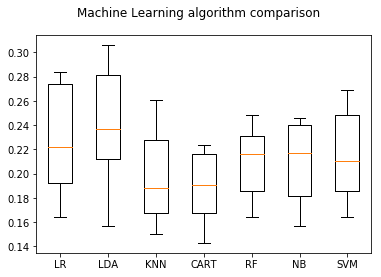

CPU times: user 4.64 s, sys: 261 ms, total: 4.9 s
Wall time: 4.79 s


In [17]:
%%time
# filter all the warnings
import warnings
warnings.filterwarnings('ignore')

# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()